Experimento usando tres subconjuntos de clustering para luego combinarlos en un solo clusterig final.

#### Imports

In [24]:
pip install tslearn

In [25]:
pip install dtaidistance

In [26]:
pip install fastdtw

In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import joblib

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import sys
import os

DATOS_DIR = os.path.abspath(os.path.join(os.getcwd(), '../Datasets/'))
ruta_absoluta = os.path.abspath(DATOS_DIR)

Dataset = os.path.abspath('g:\\My Drive\\Maestria Ciencia Analisis de datos\\Maestria Ciencia de Datos\\20_Laboratorio 3\\DataSet')

print("Ruta absoluta:", ruta_absoluta)
print("Ruta absoluta:", Dataset)
sys.path.append(DATOS_DIR)
sys.path.append(Dataset)

Ruta absoluta: /Datasets
Ruta absoluta: /content/g:\My Drive\Maestria Ciencia Analisis de datos\Maestria Ciencia de Datos\20_Laboratorio 3\DataSet


In [ ]:
#nombre_archivo = os.path.join(Dataset, 'final_dataset_descr.csv')
df = pd.read_csv('/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/final_dataset_descr.csv', sep='\t')

# Remover los 'product_id' cuya suma acumulada de 'tn' sea menor a 250
#suma_acumulada_tn = df.groupby('product_id')['tn'].sum().reset_index()
#product_ids_filtrados = suma_acumulada_tn[suma_acumulada_tn['tn'] < 250]['product_id']
#df = df[~df['product_id'].isin(product_ids_filtrados)]



#Filtrar los 'product_id' cuyo valor máximo de 'age' sea menor a 5
#max_age_per_product_id = df.groupby('product_id')['age'].max().reset_index()
#product_ids_filtrados_age = max_age_per_product_id[max_age_per_product_id['age'] < 5]['product_id']
#df = df[~df['product_id'].isin(product_ids_filtrados_age)]

In [ ]:
#df=df.drop(columns=['Unnamed: 0'])
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,quarter,month,close_quarter,age,mes_inicial
0,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,ARIEL,3000,genoma,0.0,Q1,1,0,0,2017-01-01
1,201701,10001,20002,0,17,90.13504,87.64856,HC,ROPA LAVADO,Liquido,LIMPIEX,3000,Maquina 1er lavado,0.0,Q1,1,0,0,2017-01-01
2,201701,10001,20003,0,25,100.21284,100.21284,FOODS,ADEREZOS,Mayonesa,NATURA,475,Regular sin TACC,0.0,Q1,1,0,0,2017-01-01
3,201701,10001,20004,0,13,21.73954,21.73954,FOODS,ADEREZOS,Mayonesa,NATURA,240,Regular sin TACC,0.0,Q1,1,0,0,2017-01-01
4,201701,10001,20006,0,18,31.36770,29.17196,HC,VAJILLA,Cristalino,LIMPIEX,750,Desengrasante cristal Limon,0.0,Q1,1,0,0,2017-01-01


Clustering por customer ID

In [ ]:
# Agrupar por 'customer_id' y 'periodo' y sumarizar 'tn'
df_summarized = df.groupby(['customer_id', 'periodo'])['tn'].sum().reset_index()

# Ahora, pivotamos el DataFrame para obtener una serie temporal por cliente
df_pivoted = df_summarized.pivot(index='periodo', columns='customer_id', values='tn')

# Rellenar valores NaN con ceros (opcional, dependiendo de tus necesidades)
df_pivoted = df_pivoted.fillna(0)

# Normalizar las series temporales
scaler = StandardScaler()
df_normalized = df_pivoted.apply(lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten(), axis=0)

df_normalized.head()

customer_id,10001,10002,10003,10004,10005,10006,10007,10008,10009,10010,...,10626,10629,10630,10631,10632,10633,10634,10635,10636,10637
periodo,,,,,,,,,,,,,,,,,,,,,
201701,-0.624028,1.075414,0.963536,-0.027709,-0.802878,0.028361,-1.264919,1.393049,-0.325132,0.360891,...,-0.210348,5.916080,-0.236647,-0.227185,5.916080,5.916080,-0.169031,5.164122,-0.169031,-0.169031
201702,-0.033474,-1.763648,-0.382253,-0.413256,0.062120,-0.381576,-0.990159,-0.865986,-0.142696,0.584449,...,-0.210348,-0.169031,-0.236647,5.347555,-0.169031,-0.169031,5.916080,-0.232409,5.916080,-0.169031
201703,0.940539,-0.583196,2.382345,1.693347,0.893384,0.876460,1.441863,0.841016,1.629171,0.811412,...,-0.210348,-0.169031,-0.236647,2.376725,-0.169031,-0.169031,-0.169031,2.737768,-0.169031,-0.169031
201704,0.320500,0.049140,0.336391,0.517216,-0.994226,0.828587,0.087290,0.994508,0.680422,0.369871,...,-0.210348,-0.169031,-0.236647,-0.227185,-0.169031,-0.169031,-0.169031,-0.232409,-0.169031,-0.169031
201705,0.916834,0.274483,0.727846,0.824613,1.185742,1.126505,0.658017,2.036537,1.008545,1.127760,...,-0.210348,-0.169031,-0.236647,-0.227185,-0.169031,-0.169031,-0.169031,-0.232409,-0.169031,-0.169031


Metodo 1: FASTDTW

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from dtaidistance import dtw
from tqdm import tqdm

# Convertir el DataFrame normalizado en una lista de series temporales
time_series_data = [df_normalized[customer].values.flatten() for customer in df_normalized.columns]
num_customers = len(time_series_data)
#Calcular la matriz de distancias DTW usando dtaidistance
distance_matrix = np.zeros((num_customers, num_customers))
total_comparisons = num_customers * (num_customers - 1) // 2  # Total de comparaciones

with tqdm(total=total_comparisons, desc="Calculando distancias DTW") as pbar:
    for i in range(num_customers):
        for j in range(i + 1, num_customers):
            distance = dtw.distance(time_series_data[i], time_series_data[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            pbar.update(1)  # Actualizar el contador de progreso


Calculando distancias DTW: 100%|██████████| 177906/177906 [04:45<00:00, 622.97it/s]


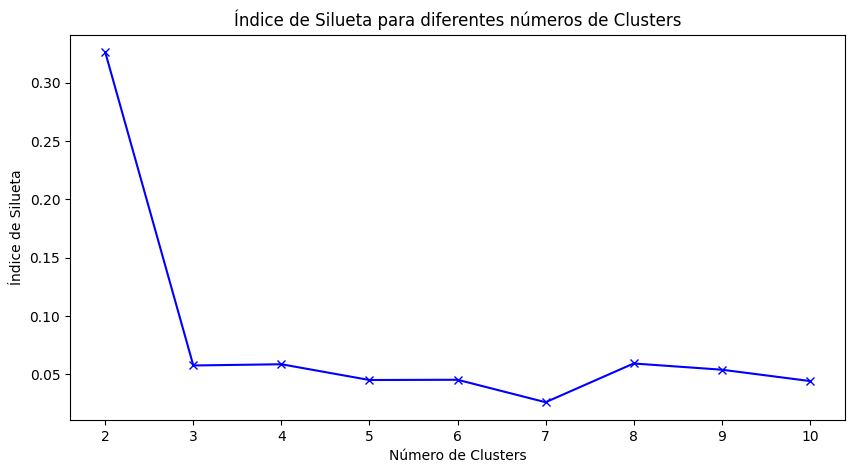

Número óptimo de clusters: 2


In [ ]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt
# Silhouette Score
silhouette_scores = []
range_n_clusters = range(2, 11)  # Probar de 2 a 10 clusters

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    cluster_labels = clustering.fit_predict(distance_matrix)

    # Calcular el índice de silueta
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

# Graficar el Índice de Silueta
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silueta para diferentes números de Clusters')
plt.show()

# Elegir el número óptimo de clusters (ejemplo: el número con el mejor índice de silueta)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_n_clusters}")

# Aplicar clustering jerárquico usando el número óptimo de clusters
clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters, metric='precomputed', linkage='complete')
cluster_labels = clustering.fit_predict(distance_matrix)

# Agregar etiquetas de clusters al DataFrame original
#df_normalized['cluster'] = cluster_labels

#tools.display_dataframe_to_user(name="Clustered DataFrame", dataframe=df_normalized)



Método 2: DTW con TimeSeriesKMeans

Clustering with different numbers of clusters: 100%|██████████| 9/9 [02:41<00:00, 17.90s/it]


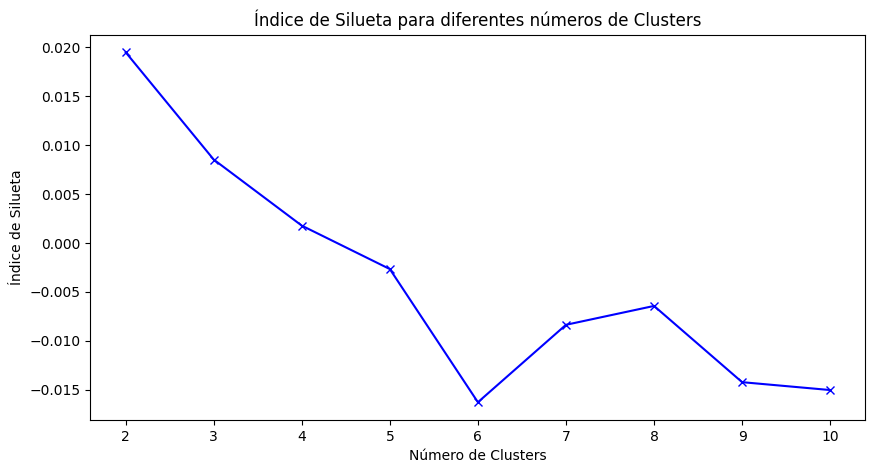

Número óptimo de clusters: 2


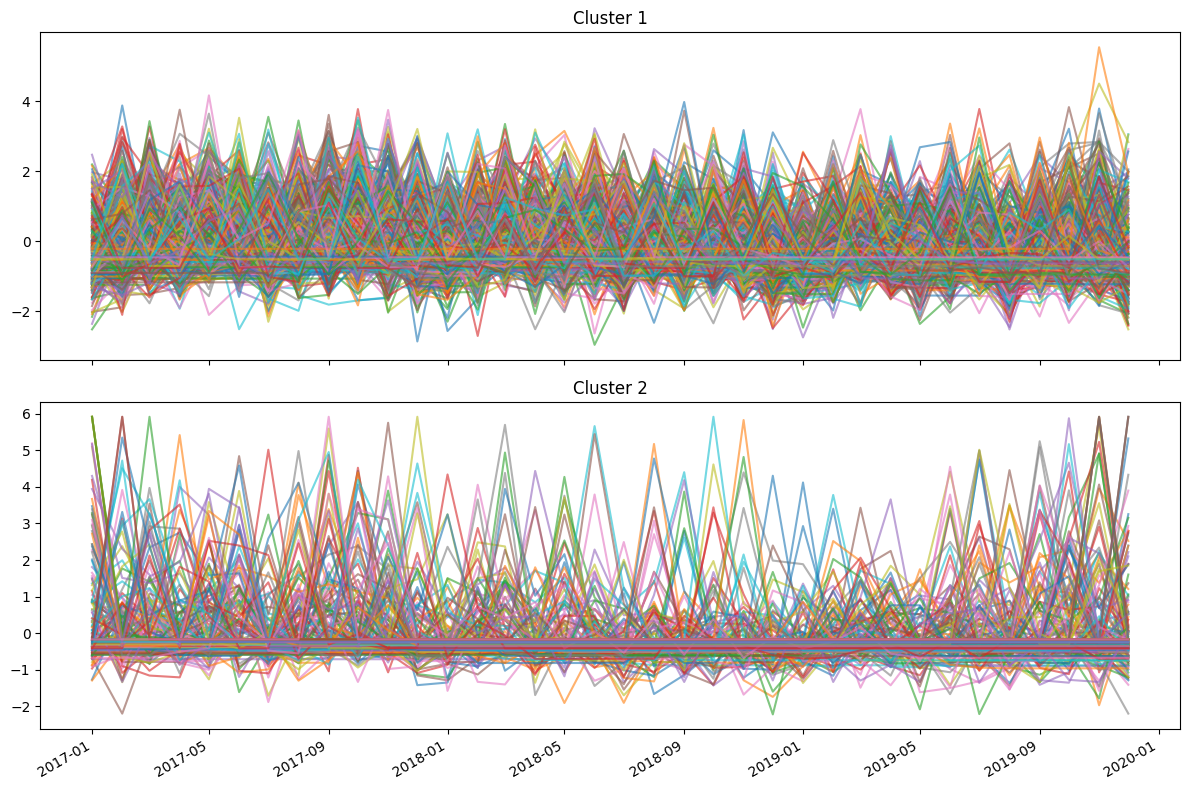

In [ ]:
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convertir el DataFrame normalizado en una lista de series temporales
time_series_data = np.array([df_normalized[customer].values for customer in df_normalized.columns])
num_customers = len(time_series_data)
num_periods = len(time_series_data[0]) if num_customers > 0 else 0
# Reshape data to fit tslearn requirements (samples, time steps, features)
time_series_data = time_series_data.reshape((num_customers, num_periods, 1))


# Silhouette Score
silhouette_scores = []
range_n_clusters = range(2, 11)  # Probar de 2 a 10 clusters

# Usar tqdm para la barra de progreso
for n_clusters in tqdm(range_n_clusters, desc="Clustering with different numbers of clusters"):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, random_state=42)
    cluster_labels = model.fit_predict(time_series_data)

    # Aplanar las series temporales
    time_series_data_flattened = time_series_data.reshape((num_customers, num_periods))

    # Calcular el índice de silueta
    silhouette_avg = silhouette_score(time_series_data_flattened, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)

# Graficar el Índice de Silueta
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silueta para diferentes números de Clusters')
plt.show()

# Elegir el número óptimo de clusters (ejemplo: el número con el mejor índice de silueta)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_n_clusters}")

# Aplicar clustering usando el número óptimo de clusters
model = TimeSeriesKMeans(n_clusters=optimal_n_clusters, metric="dtw", verbose=False, random_state=42)
cluster_labels = model.fit_predict(time_series_data)

# Agregar etiquetas de clusters al DataFrame original
df_clusters = pd.DataFrame({'customer_id': df_normalized.columns, 'cluster_cust': cluster_labels})
df_clusters.set_index('customer_id', inplace=True)

# Revertir el pivote del DataFrame normalizado
df_normalized_graph = df_normalized.T
df_normalized_graph['cluster_cust'] = df_clusters['cluster_cust']

# Mergear los clusters al DataFrame original
df_merged = df.merge(df_clusters, on='customer_id')

# Generar un vector con los 36 meses (201701 a 201912)
date_range = pd.date_range(start='2017-01-01', end='2019-12-01', freq='MS')

# Visualización de los clusters
plt.figure(figsize=(12, 8))
for cluster in range(optimal_n_clusters):
    cluster_data = df_normalized_graph[df_normalized_graph['cluster_cust'] == cluster].drop(columns=['cluster_cust']).T
    plt.subplot(optimal_n_clusters, 1, cluster + 1)
    for customer in cluster_data.columns:
        plt.plot(date_range, cluster_data[customer], label=f'Customer {customer}', alpha=0.6)
    plt.title(f'Cluster {cluster + 1}')
    #plt.legend(loc='upper right')

# Ajustar el formato del eje x para mostrar años y meses
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()


Clustering por descripción

In [ ]:
# Agrupar por 'descripcion' y 'periodo' y sumarizar 'tn'
df_summarized = df.groupby(['descripcion', 'periodo'])['tn'].sum().reset_index()

# Ahora, pivotamos el DataFrame para obtener una serie temporal por cliente
df_pivoted = df_summarized.pivot(index='periodo', columns='descripcion', values='tn')

# Rellenar valores NaN con ceros (opcional, dependiendo de tus necesidades)
df_pivoted = df_pivoted.fillna(0)

# Normalizar las series temporales
scaler = StandardScaler()
df_normalized_desc = df_pivoted.apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten(), axis=0)

df_normalized_desc.head()

descripcion,2 en 1,AA,Abrillantador,Accion Profunda,Aclarante,Acondicinador Bebe,Acondicionado 7,Acondicionador 1,Acondicionador 10,Acondicionador 11,...,reparacion,restauracion,ropa blanca,ropa negra,rulos vitales,seda delicada,sport,sport extremo,trigo,zanahoria
periodo,,,,,,,,,,,,,,,,,,,,,
201701,1.706998,-1.134042,-0.288433,1.805224,1.140536,-0.897619,0.862388,0.984647,1.192775,-1.373695,...,-1.152683,1.182775,0.304190,-0.179772,0.668518,-0.782366,-1.19117,-1.083119,-2.019011,2.415498
201702,3.333646,2.340160,-2.541055,0.670587,0.545342,-0.897619,1.302799,0.571053,2.779593,-1.373695,...,-1.152683,-0.531001,0.117874,0.229280,-0.293848,-0.782366,-1.19117,-1.083119,-3.002520,-0.278696
201703,3.426640,2.833418,0.790450,3.294239,-0.103838,-0.897619,1.654873,2.343220,0.460880,-1.373695,...,-1.152683,3.354986,0.333610,-0.537412,2.093994,-0.782366,-1.19117,-1.083119,-0.421783,0.606502
201704,2.354637,-0.175722,-0.219429,0.166806,0.692580,-0.897619,1.358170,0.953584,2.129620,-1.373695,...,-1.152683,-0.169841,-1.109513,-1.903153,-1.206803,-0.782366,-1.19117,-1.083119,1.275987,0.954656
201705,0.657185,-0.029167,1.187009,0.941161,0.457294,-0.897619,1.267425,1.022852,1.290476,-1.373695,...,-1.152683,0.098560,1.428615,3.271462,2.526107,-0.782366,4.07867,4.209986,1.396002,-0.658696


Metodo 1: FASTDTW

In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from dtaidistance import dtw
from tqdm import tqdm

# Convertir el DataFrame normalizado en una lista de series temporales
time_series_data = [df_normalized_desc[descripcion].values.flatten() for descripcion in df_normalized_desc.columns]
num_prod = len(time_series_data)
#Calcular la matriz de distancias DTW usando dtaidistance
distance_matrix = np.zeros((num_prod, num_prod))
total_comparisons = num_prod * (num_prod - 1) // 2  # Total de comparaciones

with tqdm(total=total_comparisons, desc="Calculando distancias DTW") as pbar:
    for i in range(num_prod):
        for j in range(i + 1, num_prod):
            distance = dtw.distance(time_series_data[i], time_series_data[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            pbar.update(1)  # Actualizar el contador de progreso

Calculando distancias DTW: 100%|██████████| 198135/198135 [07:14<00:00, 456.43it/s]


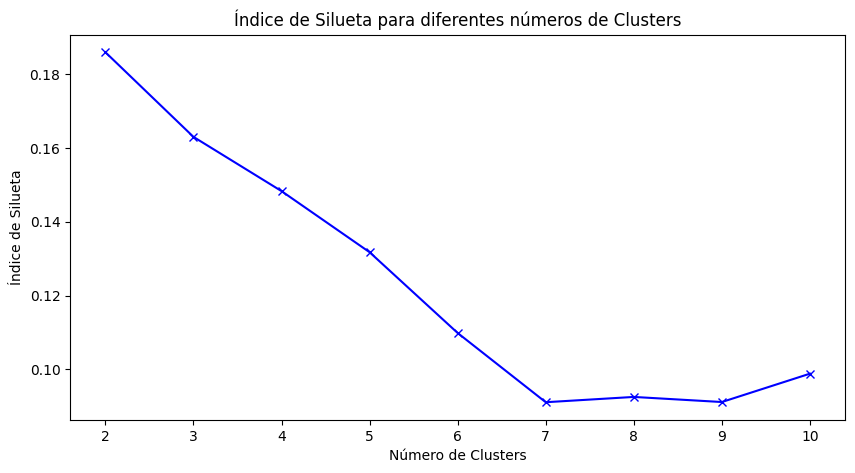

Número óptimo de clusters: 2


In [ ]:
from sklearn.metrics import silhouette_score
from tqdm import tqdm
import matplotlib.pyplot as plt
# Silhouette Score
silhouette_scores = []
range_n_clusters = range(2, 11)  # Probar de 2 a 10 clusters

for n_clusters in range_n_clusters:
    clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='precomputed', linkage='complete')
    cluster_labels = clustering.fit_predict(distance_matrix)

    # Calcular el índice de silueta
    silhouette_avg = silhouette_score(distance_matrix, cluster_labels, metric='precomputed')
    silhouette_scores.append(silhouette_avg)

# Graficar el Índice de Silueta
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silueta para diferentes números de Clusters')
plt.show()

# Elegir el número óptimo de clusters (ejemplo: el número con el mejor índice de silueta)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_n_clusters}")

# Aplicar clustering jerárquico usando el número óptimo de clusters
clustering = AgglomerativeClustering(n_clusters=optimal_n_clusters, metric='precomputed', linkage='complete')
cluster_labels = clustering.fit_predict(distance_matrix)

# Agregar etiquetas de clusters al DataFrame original
df_clusters = pd.DataFrame({'descripcion': df_normalized_desc.columns, 'cluster_desc': cluster_labels})
df_clusters.set_index('descripcion', inplace=True)

# Revertir el pivote del DataFrame normalizado
df_normalized_graph = df_normalized_desc.T
df_normalized_graph['cluster_desc'] = df_clusters['cluster_desc']

# Mergear los clusters al DataFrame original
df_merged = df_merged.merge(df_clusters, on='descripcion')

Clustering por ID combinado (customer/descrición) ----> no es viable

In [ ]:
# Paso 1: Crear 'ID_optmizado'
df['ID_optmizado'] = df['customer_id'].astype(str) + '_' + df['descripcion']

# Paso 2: Calcular el promedio de 'tn' para cada 'ID_optmizado' y 'período'
# Agrupar por 'ID_optmizado' y 'periodo' y calcular el promedio de 'tn'
df['tn_optimized'] = df.groupby(['ID_optmizado', 'periodo'])['tn'].transform('sum')

# Paso 3: Calcular la proporción de 'tn' para cada 'product_id' dentro de cada 'ID_optmizado' y 'período'
df['tn_proporcion'] = df['tn'] / df['tn_optimized']


In [ ]:
df.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,...,descripcion,stock_final,quarter,month,close_quarter,age,mes_inicial,ID_optmizado,tn_optimized,tn_proporcion
0,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q1,1,0,0,2017-01-01,10001_genoma,112.18296,0.886397
1,201701,10001,20002,0,17,90.13504,87.64856,HC,ROPA LAVADO,Liquido,...,Maquina 1er lavado,0.0,Q1,1,0,0,2017-01-01,10001_Maquina 1er lavado,149.43140,0.586547
2,201701,10001,20003,0,25,100.21284,100.21284,FOODS,ADEREZOS,Mayonesa,...,Regular sin TACC,0.0,Q1,1,0,0,2017-01-01,10001_Regular sin TACC,149.69127,0.669463
3,201701,10001,20004,0,13,21.73954,21.73954,FOODS,ADEREZOS,Mayonesa,...,Regular sin TACC,0.0,Q1,1,0,0,2017-01-01,10001_Regular sin TACC,149.69127,0.145229
4,201701,10001,20006,0,18,31.36770,29.17196,HC,VAJILLA,Cristalino,...,Desengrasante cristal Limon,0.0,Q1,1,0,0,2017-01-01,10001_Desengrasante cristal Limon,39.13992,0.745325


In [ ]:
# Agrupar por 'ID_optmizado' y 'periodo' y sumarizar 'tn'
df_summarized = df.groupby(['ID_optmizado', 'periodo'])['tn'].sum().reset_index()

# Ahora, pivotamos el DataFrame para obtener una serie temporal por cliente
df_pivoted = df_summarized.pivot(index='periodo', columns='ID_optmizado', values='tn')

# Rellenar valores NaN con ceros (opcional, dependiendo de tus necesidades)
df_pivoted = df_pivoted.fillna(0)

# Normalizar las series temporales
scaler = StandardScaler()
df_normalized_desc = df_pivoted.apply(lambda x: StandardScaler().fit_transform(x.values.reshape(-1, 1)).flatten(), axis=0)

df_normalized_desc.head()

ID_optmizado,10001_2 en 1,10001_AA,10001_Abrillantador,10001_Accion Profunda,10001_Aclarante,10001_Acondicinador Bebe,10001_Acondicionado 7,10001_Acondicionador 1,10001_Acondicionador 10,10001_Acondicionador 11,...,10635_Suave sin TACC,10635_Tradicinal,10635_Velocidad,10635_oleo,10636_Estilo 16,10636_Sabor 1,10636_ceramidas,10636_peinado3,10637_Sabor 1,10637_Sabor 2
periodo,,,,,,,,,,,,,,,,,,,,,
201701,3.171689,-0.163381,-1.281830,0.384374,0.707154,-0.169031,1.776585,0.324563,1.909537,-1.009179,...,-0.169031,-0.169031,5.266115,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031
201702,2.815135,1.223436,-0.367205,0.048371,-0.143185,-0.169031,1.655376,-0.644243,1.278086,-1.009179,...,-0.169031,-0.169031,-0.229720,-0.169031,5.916080,5.916080,5.916080,5.916080,-0.169031,-0.169031
201703,2.815135,3.281808,-1.022104,1.227059,-0.005894,-0.169031,2.929635,1.026428,1.289345,-1.009179,...,5.916080,5.916080,2.544368,5.916080,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031
201704,2.130181,-0.472944,0.714763,0.216301,0.050840,-0.169031,0.878787,-0.402461,-1.055845,-1.009179,...,-0.169031,-0.169031,-0.229720,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031
201705,0.985469,-0.281022,-0.506777,0.048371,2.653015,-0.169031,0.408711,-0.132226,1.063849,-1.009179,...,-0.169031,-0.169031,-0.229720,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031,-0.169031


In [ ]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
from sklearn.cluster import AgglomerativeClustering
from dtaidistance import dtw
from tqdm import tqdm

# Convertir el DataFrame normalizado en una lista de series temporales
time_series_data = [df_normalized_desc[descripcion].values.flatten() for descripcion in df_normalized_desc.columns]
num_prod = len(time_series_data)
#Calcular la matriz de distancias DTW usando dtaidistance
distance_matrix = np.zeros((num_prod, num_prod))
total_comparisons = num_prod * (num_prod - 1) // 2  # Total de comparaciones

with tqdm(total=total_comparisons, desc="Calculando distancias DTW") as pbar:
    for i in range(num_prod):
        for j in range(i + 1, num_prod):
            distance = dtw.distance(time_series_data[i], time_series_data[j])
            distance_matrix[i, j] = distance
            distance_matrix[j, i] = distance
            pbar.update(1)  # Actualizar el contador de progreso

Calculando distancias DTW:   0%|          | 50099/21090164131 [02:01<14162:12:48, 413.66it/s]


KeyboardInterrupt: 

Clustering por ProductID

In [ ]:
from sklearn.preprocessing import RobustScaler
# Agrupar por 'ID_optmizado' y 'periodo' y sumarizar 'tn'
df_summarized = df.groupby(['product_id', 'periodo'])['tn'].sum().reset_index()

# Ahora, pivotamos el DataFrame para obtener una serie temporal por cliente
df_pivoted = df_summarized.pivot(index='periodo', columns='product_id', values='tn')

# Rellenar valores NaN con ceros (opcional, dependiendo de tus necesidades)
df_pivoted = df_pivoted.fillna(0)

# Normalizar las series temporales
scaler = StandardScaler()
#scaler = RobustScaler()
df_normalized_prod = df_pivoted.apply(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten(), axis=0)

df_normalized_prod.head()

product_id,20001,20002,20003,20004,20005,20006,20007,20008,20009,20010,...,21264,21265,21266,21267,21269,21271,21276,21282,21287,21294
periodo,,,,,,,,,,,,,,,,,,,,,
201701,-1.576908,-1.532823,0.605845,-0.522791,-0.696637,-0.359216,-0.704551,-0.195091,-0.800891,-0.345959,...,-1.0843,-0.368008,-0.38748,-0.447109,-0.473124,-1.01348,-0.423164,3.346709,5.916080,-0.169031
201702,-2.042103,-1.680597,-0.475388,-0.738396,-0.431046,0.083794,0.129480,0.487176,0.053152,0.198234,...,-1.0843,-0.368008,-0.38748,-0.447109,-0.473124,-1.01348,-0.423164,4.780865,-0.169031,-0.169031
201703,-0.323111,-0.582916,0.097798,-0.821027,-0.373111,1.768530,1.098926,2.406556,-0.115346,0.893257,...,-1.0843,-0.368008,-0.38748,-0.447109,-0.473124,-1.01348,-0.423164,-0.239046,-0.169031,-0.169031
201704,-1.117043,-1.625630,-1.261246,-0.720983,0.085446,-0.128189,0.621107,0.454549,-1.146895,0.398273,...,-1.0843,-0.368008,-0.38748,-0.447109,-0.473124,-1.01348,-0.423164,-0.239046,-0.169031,-0.169031
201705,0.353285,-0.553867,-0.932524,-0.579496,-0.597590,1.423232,1.181448,1.854466,-0.121514,1.079002,...,-1.0843,-0.368008,-0.38748,-0.447109,-0.473124,-1.01348,-0.423164,-0.239046,-0.169031,-0.169031


Clustering with different numbers of clusters: 100%|██████████| 10/10 [07:48<00:00, 46.85s/it]


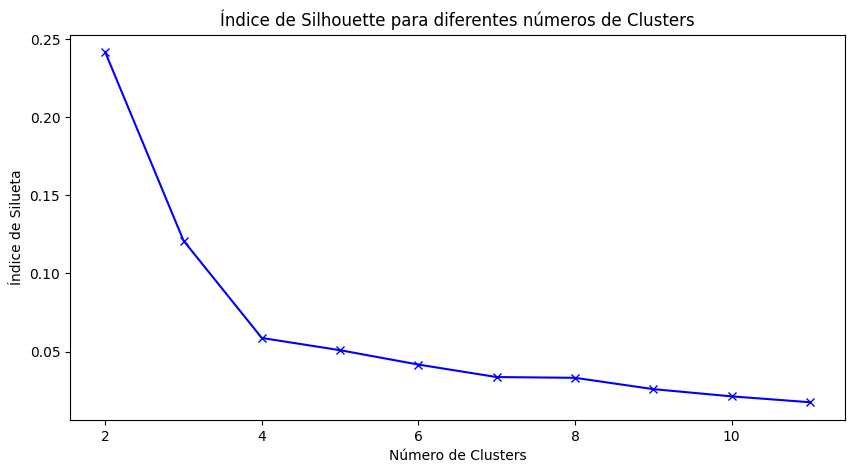

Número óptimo de clusters: 2


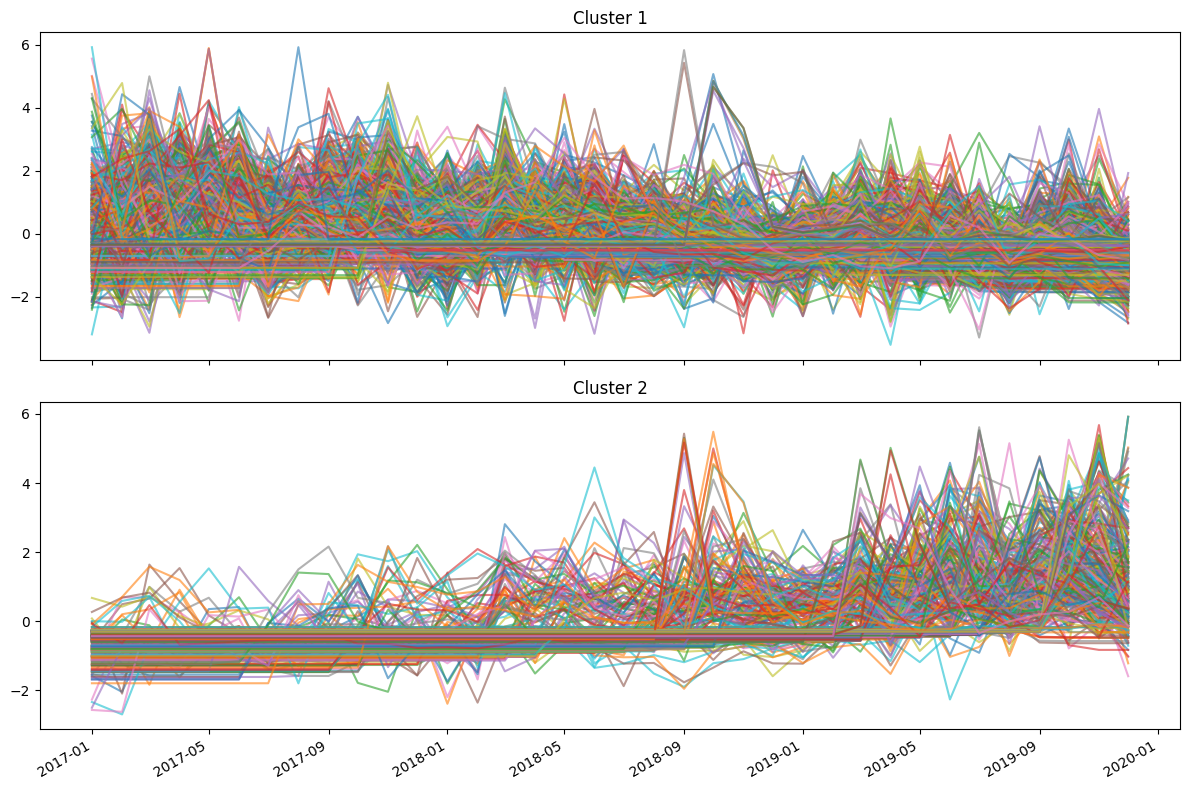

In [ ]:
from sklearn.preprocessing import StandardScaler
from tslearn.clustering import TimeSeriesKMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Convertir el DataFrame normalizado en una lista de series temporales
time_series_data = np.array([df_normalized_prod[product].values for product in df_normalized_prod.columns])
num_customers = len(time_series_data)
num_periods = len(time_series_data[0]) if num_customers > 0 else 0
# Reshape data to fit tslearn requirements (samples, time steps, features)
time_series_data = time_series_data.reshape((num_customers, num_periods, 1))


# Silhouette Score
silhouette_scores = []
range_n_clusters = range(2, 12)  # Probar de 2 a 10 clusters

# Usar tqdm para la barra de progreso
for n_clusters in tqdm(range_n_clusters, desc="Clustering with different numbers of clusters"):
    model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw", verbose=False, random_state=42)
    cluster_labels = model.fit_predict(time_series_data)

    # Aplanar las series temporales
    time_series_data_flattened = time_series_data.reshape((num_customers, num_periods))

    # Calcular el índice de silueta
    silhouette_avg = silhouette_score(time_series_data_flattened, cluster_labels, metric="euclidean")
    silhouette_scores.append(silhouette_avg)

# Graficar el Índice de Silueta
plt.figure(figsize=(10, 5))
plt.plot(range_n_clusters, silhouette_scores, 'bx-')
plt.xlabel('Número de Clusters')
plt.ylabel('Índice de Silueta')
plt.title('Índice de Silhouette para diferentes números de Clusters')
plt.show()

# Elegir el número óptimo de clusters (ejemplo: el número con el mejor índice de silueta)
optimal_n_clusters = range_n_clusters[np.argmax(silhouette_scores)]
print(f"Número óptimo de clusters: {optimal_n_clusters}")

# Aplicar clustering usando el número óptimo de clusters
model = TimeSeriesKMeans(n_clusters=optimal_n_clusters, metric="dtw", verbose=False, random_state=42)
cluster_labels = model.fit_predict(time_series_data)

# Agregar etiquetas de clusters al DataFrame original
df_clusters = pd.DataFrame({'product_id': df_normalized_prod.columns, 'cluster_prod_id': cluster_labels})
df_clusters.set_index('product_id', inplace=True)

# Revertir el pivote del DataFrame normalizado
df_normalized_graph = df_normalized_prod.T
df_normalized_graph['cluster_prod_id'] = df_clusters['cluster_prod_id']

# Mergear los clusters al DataFrame original
df_merged = df_merged.merge(df_clusters, on='product_id')

# Generar un vector con los 36 meses (201701 a 201912)
date_range = pd.date_range(start='2017-01-01', end='2019-12-01', freq='MS')

# Visualización de los clusters
plt.figure(figsize=(12, 8))
for cluster in range(optimal_n_clusters):
    cluster_data = df_normalized_graph[df_normalized_graph['cluster_prod_id'] == cluster].drop(columns=['cluster_prod_id']).T
    plt.subplot(optimal_n_clusters, 1, cluster + 1)
    for customer in cluster_data.columns:
        plt.plot(date_range, cluster_data[customer], label=f'Customer {customer}', alpha=0.6)
    plt.title(f'Cluster {cluster + 1}')
    #plt.legend(loc='upper right')

# Ajustar el formato del eje x para mostrar años y meses
plt.gcf().autofmt_xdate()
plt.tight_layout()
plt.show()

In [ ]:
df_merged.head()

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,...,descripcion,stock_final,quarter,month,close_quarter,age,mes_inicial,cluster_cust,cluster_desc,cluster_prod_id
0,201701,10001,20001,0,11,99.43861,99.43861,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q1,1,0,0,2017-01-01,0,0,1
1,201702,10001,20001,0,23,198.84365,198.84365,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q1,2,0,1,2017-01-01,0,0,1
2,201703,10001,20001,0,33,92.46537,92.46537,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q1,3,1,2,2017-01-01,0,0,1
3,201704,10001,20001,0,8,13.29728,13.29728,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q2,4,0,3,2017-01-01,0,0,1
4,201705,10001,20001,0,15,101.20711,101.00563,HC,ROPA LAVADO,Liquido,...,genoma,0.0,Q2,5,0,4,2017-01-01,0,0,1


In [ ]:
df_p=df_merged
# Concatenar las columnas 'cluster_cust', 'cluster_desc' y 'cluster_prod_id' en una sola columna temporal
df_p['temp_combination'] = df_p[['cluster_cust', 'cluster_desc', 'cluster_prod_id']].astype(str).agg('-'.join, axis=1)

# Factorizar la columna temporal para obtener valores numéricos únicos
df_p['cluster'], _ = pd.factorize(df_p['temp_combination'])

# Eliminar la columna temporal
df_p = df_p.drop(columns=['temp_combination','cluster_cust', 'cluster_desc', 'cluster_prod_id'])


In [ ]:
# Contar el número de valores únicos en la columna 'cluster'
num_unique_clusters = df_p['cluster'].nunique()
print(f"Número de valores únicos en la columna 'cluster': {num_unique_clusters}")
#Salvar
df_p.to_csv('/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/dataset_cluster.csv', index=False)

Número de valores únicos en la columna 'cluster': 8


In [30]:
df_p = pd.read_csv('/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/dataset_cluster.csv')

#### Paso 3: Aplicar LabelEncoder a las columnas categóricas


In [31]:
categorical_cols = ['cat1', 'cat2', 'cat3', 'brand', 'descripcion', 'quarter']

# Aplicar LabelEncoder
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df_p[col] = le.fit_transform(df_p[col])
    label_encoders[col] = le

display(df_p)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,quarter,month,close_quarter,age,mes_inicial,cluster
0,201701,10001,20001,0,11,99.43861,99.43861,1,10,54,0,3000,568,0.00000,0,1,0,0,2017-01-01,0
1,201702,10001,20001,0,23,198.84365,198.84365,1,10,54,0,3000,568,0.00000,0,2,0,1,2017-01-01,0
2,201703,10001,20001,0,33,92.46537,92.46537,1,10,54,0,3000,568,0.00000,0,3,1,2,2017-01-01,0
3,201704,10001,20001,0,8,13.29728,13.29728,1,10,54,0,3000,568,0.00000,1,4,0,3,2017-01-01,0
4,201705,10001,20001,0,15,101.20711,101.00563,1,10,54,0,3000,568,0.00000,1,5,0,4,2017-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938365,201912,10380,20854,0,1,0.01802,0.01802,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938366,201912,10499,20854,0,1,0.01802,0.01802,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938367,201912,10465,20854,0,1,0.03604,0.03604,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938368,201912,10373,20854,0,1,0.03604,0.03604,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1


#### Paso 4: Aplicar escalers por columna a cada grupo


In [32]:
# Crear un diccionario para almacenar los scalers
scalers = {}
scaled_df = df_p.copy()

# Aplicar StandardScaler a cada columna de interés
for col in ['cust_request_qty', 'cust_request_tn', 'tn']:
    scaler = StandardScaler()
    scaled_df[col] = scaler.fit_transform(scaled_df[[col]])
    scalers[col] = scaler

# Guardar los scalers para su uso posterior
joblib.dump(scalers, '/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/scalers_pID.pkl')


['/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/scalers_pID.pkl']

In [ ]:
display(scaled_df)

,periodo,customer_id,product_id,plan_precios_cuidados,cust_request_qty,cust_request_tn,tn,cat1,cat2,cat3,brand,sku_size,descripcion,stock_final,quarter,month,close_quarter,age,mes_inicial,cluster
0,201701,10001,20001,0,2.477829,30.673919,31.806772,1,10,54,0,3000,568,0.00000,0,1,0,0,2017-01-01,0
1,201702,10001,20001,0,5.837147,61.480104,63.747609,1,10,54,0,3000,568,0.00000,0,2,0,1,2017-01-01,0
2,201703,10001,20001,0,8.636578,28.512873,29.566129,1,10,54,0,3000,568,0.00000,0,3,1,2,2017-01-01,0
3,201704,10001,20001,0,1.638000,3.978234,4.127831,1,10,54,0,3000,568,0.00000,1,4,0,3,2017-01-01,0
4,201705,10001,20001,0,3.597602,31.221987,32.310287,1,10,54,0,3000,568,0.00000,1,5,0,4,2017-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938365,201912,10380,20854,0,-0.321602,-0.137084,-0.139062,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938366,201912,10499,20854,0,-0.321602,-0.137084,-0.139062,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938367,201912,10465,20854,0,-0.321602,-0.131499,-0.133272,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1
2938368,201912,10373,20854,0,-0.321602,-0.131499,-0.133272,1,8,76,13,5000,505,45.92788,3,12,1,0,2019-12-01,1


Paso 5: Definir vector de pesos

In [39]:
# Agrupar por 'product_id' y calcular el peso basado en 'tn'
weight_mapping = scaled_df.groupby('product_id')['tn'].mean().abs().to_dict()

# Asignar el peso correspondiente a cada fila en el DataFrame
scaled_df['weights'] = scaled_df['product_id'].map(weight_mapping)

#### Paso 6: Armar un modelo LSTM


In [60]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense
from keras.regularizers import l2
import numpy as np

le_factor = 0.01

def build_lstm_model(input_shape, cluster):
    model = Sequential()
    model.add(LSTM(128, activation='tanh', return_sequences=True, kernel_regularizer=l2(le_factor), input_shape=input_shape))
    model.add(Dropout(0.1))
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))

    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(512, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(256, activation='tanh', kernel_regularizer=l2(le_factor), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(128, activation='tanh', kernel_regularizer=l2(le_factor)))
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='tanh', kernel_regularizer=l2(le_factor)))
    model.add(Dense(64, activation='tanh', kernel_regularizer=l2(le_factor)))
    model.add(Dense(32, activation='tanh'))
    model.add(Dense(1))
    #model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error', weighted_metrics=[])
    return model

In [38]:
cluster_counts = scaled_df['cluster'].value_counts()
display(cluster_counts)

cluster
4    1179287
2    1035081
0     293803
5     190763
3     167624
1      46221
6      21990
7       3601
Name: count, dtype: int64

#### Paso 7: Entrenar y predecir con el modelo LSTM para cada grupo


In [44]:
from keras.callbacks import Callback
import time
from tqdm import tqdm

class TQDMProgressBar(Callback):
    def __init__(self, epochs):
        super().__init__()
        self.epochs = epochs
        self.epoch_bar = None
        self.start_time = None

    def on_train_begin(self, logs=None):
        self.epoch_bar = tqdm(total=self.epochs, desc="Training Progress", unit="epoch")
        self.start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_bar.update(1)
        elapsed_time = time.time() - self.start_time
        avg_time_per_epoch = elapsed_time / (epoch + 1)
        remaining_time = avg_time_per_epoch * (self.epochs - (epoch + 1))
        self.epoch_bar.set_postfix({
            'loss': logs.get('loss', 0.0),
            'val_loss': logs.get('val_loss', 0.0),
            'elapsed_time': f"{elapsed_time:.2f}s",
            'remaining_time': f"{remaining_time:.2f}s",
            'progress': f"{100 * (epoch + 1) / self.epochs:.2f}%"
        })

    def on_train_end(self, logs=None):
        self.epoch_bar.close()

In [64]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import numpy as np
import pandas as pd

models = {}
predictions = []

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001, verbose=1)
sample_weights = scaled_df['weights'].values

# Definir la ruta del directorio
directory_path = "/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/"

# Preparar los datos por cluster
scaler_tn = scalers['tn']
for cluster in range(n_clusters):
    print(f'Entrenando cluster numero: {cluster}')
    cluster_data = scaled_df[scaled_df['cluster'] == cluster].copy()
    cluster_data.sort_values(by='periodo', inplace=True)

    # Desplazar 'tn' dos meses hacia atrás
    #cluster_data['tn_shifted'] = cluster_data['tn'].shift(-2)

    # Eliminar filas con valores NaN después del desplazamiento
    #cluster_data.dropna(subset=['tn_shifted'], inplace=True)

    # Filtrar solo los períodos de 2019
    periodos_X = list(range(201901, 201911))  # 201901 a 201910
    periodos_y = list(range(201903, 201913))  # 201903 a 201912

    # Preparar los datos para LSTM
    X, y = [], []
    for key, data in cluster_data.groupby(['cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'product_id']):
        series = data[['cat1', 'cat2', 'cat3', 'brand', 'quarter', 'month', 'customer_id', 'product_id', 'periodo','tn']].values
        series_shifted = data[['tn']].values

        # Filtrar los periodos de interés para X (201901 a 201910) y y (201903 a 201912)
        series_X = series[np.isin(data['periodo'], periodos_X)]
        series_y = series_shifted[np.isin(data['periodo'], periodos_y)]

        if len(series_X) > 2 and len(series_y) > 2:  # Asegurarse de que haya suficientes datos
            X.append(series_X[:, :-1])  # Todos los datos excepto el último valor que es 'periodo'
            y.append(series_y.flatten())  # Eliminar los primeros 2 valores desplazados

    max_len = max(len(seq) for seq in X)
    X_padded = np.array([np.pad(seq, ((max_len - len(seq), 0), (0, 0)), mode='constant') for seq in X]).astype(np.float32)
    y_padded = np.array([np.pad(seq, (0, (max_len - len(seq))), mode='constant') for seq in y]).astype(np.float32)

    if len(X_padded) == 0 or len(y_padded) == 0:
        continue

    early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True, verbose=1)

    # Construir y entrenar el modelo
    model = build_lstm_model((X_padded.shape[1], X_padded.shape[2]), cluster)
    tqdm_callback = TQDMProgressBar(epochs=400)  # Ajustar el número de epochs según sea necesario
    model.fit(X_padded, y_padded, epochs=400, verbose=0, batch_size=256, validation_split=0.2, callbacks=[reduce_lr, early_stopping, tqdm_callback], sample_weight=sample_weights )
    models[cluster] = model

    #Hacer predicciones
    for key, data in cluster_data.groupby(['cat1', 'cat2', 'cat3', 'brand', 'customer_id', 'product_id']):
        series = data[['cat1', 'cat2', 'cat3', 'brand', 'quarter', 'month', 'customer_id', 'product_id', 'periodo', 'tn']].values

        # Filtrar los períodos 201903 a 201912 para la predicción
        series_2019 = series[(data['periodo'] >= 201903) & (data['periodo'] <= 201912)]

        if len(series_2019) == 10:  # Asegurarse de que haya exactamente 10 períodos
            X_pred = series_2019[:, :-1]  # Excluir 'periodo' de las características
            X_pred = np.reshape(X_pred, (1, X_pred.shape[0], X_pred.shape[1]))  # Reshape para (1, 10, n_features)
            pred = model.predict(X_pred, verbose=0)
            inverse_pred = scaler_tn.inverse_transform(pred)[0][0]
            predictions.append([key[0], key[1], key[2], key[3], inverse_pred, key[4], key[5]])

    pred_df_temp = pd.DataFrame(predictions, columns=['cat1', 'cat2', 'cat3', 'brand', 'prediccion', 'customer_id', 'product_id'])
    pred_df_temp.to_csv(f"{directory_path}predicciones_temprales_cluster_pID{cluster}.csv", index=False)

Entrenando cluster numero: 0



Training Progress:   3%|▎         | 11/400 [00:41<18:36,  2.87s/epoch, loss=7.06, val_loss=0.0068, elapsed_time=41.88s, remaining_time=1481.11s, progress=2.75%] 


Epoch 12: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:   4%|▎         | 14/400 [00:49<17:40,  2.75s/epoch, loss=7.06, val_loss=0.00695, elapsed_time=49.96s, remaining_time=1377.57s, progress=3.50%]


Epoch 15: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:   4%|▍         | 17/400 [00:57<17:03,  2.67s/epoch, loss=7.06, val_loss=0.00707, elapsed_time=57.87s, remaining_time=1303.81s, progress=4.25%]


Epoch 18: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:  10%|▉         | 38/400 [01:53<15:53,  2.63s/epoch, loss=7.06, val_loss=0.00702, elapsed_time=113.16s, remaining_time=1078.04s, progress=9.50%]

Restoring model weights from the end of the best epoch: 9.



Training Progress:  10%|▉         | 39/400 [01:55<15:54,  2.64s/epoch, loss=7.06, val_loss=0.00702, elapsed_time=115.83s, remaining_time=1072.21s, progress=9.75%]

Epoch 39: early stopping


Training Progress:  10%|▉         | 39/400 [01:55<17:52,  2.97s/epoch, loss=7.06, val_loss=0.00702, elapsed_time=115.83s, remaining_time=1072.21s, progress=9.75%]


Entrenando cluster numero: 1



Training Progress:   9%|▉         | 35/400 [00:27<02:39,  2.29epoch/s, loss=0.858, val_loss=0.0222, elapsed_time=27.31s, remaining_time=284.84s, progress=8.75%]


Epoch 36: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:  10%|█         | 40/400 [00:29<02:36,  2.30epoch/s, loss=0.857, val_loss=0.0219, elapsed_time=29.52s, remaining_time=265.64s, progress=10.00%]


Epoch 41: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:  11%|█         | 43/400 [00:30<02:32,  2.34epoch/s, loss=0.857, val_loss=0.0219, elapsed_time=30.79s, remaining_time=255.63s, progress=10.75%]


Epoch 44: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:  17%|█▋        | 67/400 [00:41<02:23,  2.32epoch/s, loss=0.857, val_loss=0.0218, elapsed_time=41.12s, remaining_time=204.36s, progress=16.75%]

Restoring model weights from the end of the best epoch: 38.



Training Progress:  17%|█▋        | 68/400 [00:41<02:26,  2.27epoch/s, loss=0.857, val_loss=0.0218, elapsed_time=41.58s, remaining_time=202.99s, progress=17.00%]

Epoch 68: early stopping


Training Progress:  17%|█▋        | 68/400 [00:41<03:23,  1.64epoch/s, loss=0.857, val_loss=0.0218, elapsed_time=41.58s, remaining_time=202.99s, progress=17.00%]


Entrenando cluster numero: 2



Training Progress:   2%|▏         | 6/400 [00:44<40:04,  6.10s/epoch, loss=0.929, val_loss=0.00444, elapsed_time=44.05s, remaining_time=2892.94s, progress=1.50%]


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:   2%|▏         | 9/400 [00:59<35:54,  5.51s/epoch, loss=0.928, val_loss=0.00458, elapsed_time=59.82s, remaining_time=2598.92s, progress=2.25%]


Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:   3%|▎         | 12/400 [01:15<34:14,  5.30s/epoch, loss=0.928, val_loss=0.00464, elapsed_time=75.39s, remaining_time=2437.46s, progress=3.00%]


Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:   8%|▊         | 33/400 [03:04<31:42,  5.18s/epoch, loss=0.928, val_loss=0.00461, elapsed_time=184.31s, remaining_time=2049.80s, progress=8.25%]

Restoring model weights from the end of the best epoch: 4.



Training Progress:   8%|▊         | 34/400 [03:09<31:40,  5.19s/epoch, loss=0.928, val_loss=0.00464, elapsed_time=189.53s, remaining_time=2040.23s, progress=8.50%]

Epoch 34: early stopping


Training Progress:   8%|▊         | 34/400 [03:09<34:00,  5.57s/epoch, loss=0.928, val_loss=0.00464, elapsed_time=189.53s, remaining_time=2040.23s, progress=8.50%]


Entrenando cluster numero: 3



Training Progress:   6%|▌         | 22/400 [00:30<05:18,  1.19epoch/s, loss=0.254, val_loss=0.0276, elapsed_time=30.32s, remaining_time=520.88s, progress=5.50%]


Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:   6%|▋         | 25/400 [00:32<05:12,  1.20epoch/s, loss=0.253, val_loss=0.0272, elapsed_time=32.80s, remaining_time=492.03s, progress=6.25%]


Epoch 26: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:   7%|▋         | 28/400 [00:35<05:09,  1.20epoch/s, loss=0.253, val_loss=0.0272, elapsed_time=35.29s, remaining_time=468.89s, progress=7.00%]


Epoch 29: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:  12%|█▏        | 49/400 [00:52<04:49,  1.21epoch/s, loss=0.253, val_loss=0.0272, elapsed_time=52.69s, remaining_time=377.44s, progress=12.25%]

Restoring model weights from the end of the best epoch: 20.



Training Progress:  12%|█▎        | 50/400 [00:53<04:52,  1.20epoch/s, loss=0.253, val_loss=0.0272, elapsed_time=53.55s, remaining_time=374.85s, progress=12.50%]

Epoch 50: early stopping


Training Progress:  12%|█▎        | 50/400 [00:53<06:14,  1.07s/epoch, loss=0.253, val_loss=0.0272, elapsed_time=53.55s, remaining_time=374.85s, progress=12.50%]


Entrenando cluster numero: 4



Training Progress:   2%|▏         | 6/400 [00:39<35:00,  5.33s/epoch, loss=0.322, val_loss=0.0166, elapsed_time=39.82s, remaining_time=2614.60s, progress=1.50%]


Epoch 7: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:   2%|▏         | 9/400 [00:53<31:30,  4.83s/epoch, loss=0.321, val_loss=0.0173, elapsed_time=53.64s, remaining_time=2330.33s, progress=2.25%]


Epoch 10: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:   3%|▎         | 12/400 [01:07<30:01,  4.64s/epoch, loss=0.321, val_loss=0.0169, elapsed_time=67.30s, remaining_time=2176.12s, progress=3.00%]


Epoch 13: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:   9%|▉         | 35/400 [02:51<27:33,  4.53s/epoch, loss=0.321, val_loss=0.0169, elapsed_time=171.50s, remaining_time=1788.48s, progress=8.75%]

Restoring model weights from the end of the best epoch: 6.



Training Progress:   9%|▉         | 36/400 [02:56<27:32,  4.54s/epoch, loss=0.321, val_loss=0.0169, elapsed_time=176.06s, remaining_time=1780.15s, progress=9.00%]

Epoch 36: early stopping


Training Progress:   9%|▉         | 36/400 [02:56<29:40,  4.89s/epoch, loss=0.321, val_loss=0.0169, elapsed_time=176.06s, remaining_time=1780.15s, progress=9.00%]


Entrenando cluster numero: 5



Training Progress:   6%|▌         | 24/400 [00:29<04:42,  1.33epoch/s, loss=0.27, val_loss=0.0221, elapsed_time=29.97s, remaining_time=469.49s, progress=6.00%]


Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:   7%|▋         | 27/400 [00:32<04:35,  1.35epoch/s, loss=0.27, val_loss=0.0221, elapsed_time=32.17s, remaining_time=444.41s, progress=6.75%]


Epoch 28: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:   8%|▊         | 30/400 [00:34<04:30,  1.37epoch/s, loss=0.27, val_loss=0.0222, elapsed_time=34.36s, remaining_time=423.72s, progress=7.50%]


Epoch 31: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:  13%|█▎        | 51/400 [00:49<04:14,  1.37epoch/s, loss=0.27, val_loss=0.0223, elapsed_time=49.66s, remaining_time=339.82s, progress=12.75%]

Restoring model weights from the end of the best epoch: 22.



Training Progress:  13%|█▎        | 52/400 [00:50<04:16,  1.36epoch/s, loss=0.27, val_loss=0.0223, elapsed_time=50.42s, remaining_time=337.41s, progress=13.00%]

Epoch 52: early stopping


Training Progress:  13%|█▎        | 52/400 [00:50<05:37,  1.03epoch/s, loss=0.27, val_loss=0.0223, elapsed_time=50.42s, remaining_time=337.41s, progress=13.00%]


Entrenando cluster numero: 6



Training Progress:  15%|█▍        | 59/400 [00:25<01:18,  4.32epoch/s, loss=0.457, val_loss=0.0376, elapsed_time=25.96s, remaining_time=150.06s, progress=14.75%]


Epoch 60: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:  16%|█▌        | 62/400 [00:26<01:16,  4.43epoch/s, loss=0.46, val_loss=0.0334, elapsed_time=26.63s, remaining_time=145.18s, progress=15.50%] 


Epoch 63: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:  16%|█▋        | 65/400 [00:27<01:14,  4.47epoch/s, loss=0.457, val_loss=0.0287, elapsed_time=27.30s, remaining_time=140.69s, progress=16.25%]


Epoch 66: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress:  22%|██▏       | 86/400 [00:31<01:09,  4.50epoch/s, loss=0.456, val_loss=0.0257, elapsed_time=31.98s, remaining_time=116.75s, progress=21.50%]

Restoring model weights from the end of the best epoch: 57.



Training Progress:  22%|██▏       | 87/400 [00:32<01:12,  4.33epoch/s, loss=0.456, val_loss=0.0257, elapsed_time=32.23s, remaining_time=115.95s, progress=21.75%]

Epoch 87: early stopping


Training Progress:  22%|██▏       | 87/400 [00:32<01:55,  2.70epoch/s, loss=0.456, val_loss=0.0257, elapsed_time=32.23s, remaining_time=115.95s, progress=21.75%]


Entrenando cluster numero: 7



Training Progress:  73%|███████▎  | 291/400 [00:35<00:08, 12.26epoch/s, loss=0.0238, val_loss=0.0178, elapsed_time=35.71s, remaining_time=13.38s, progress=72.75%]


Epoch 292: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.



Training Progress:  74%|███████▍  | 295/400 [00:36<00:08, 12.16epoch/s, loss=0.0237, val_loss=0.0177, elapsed_time=36.04s, remaining_time=12.83s, progress=73.75%]


Epoch 296: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.



Training Progress:  74%|███████▍  | 298/400 [00:36<00:08, 12.18epoch/s, loss=0.0237, val_loss=0.0177, elapsed_time=36.29s, remaining_time=12.42s, progress=74.50%]


Epoch 299: ReduceLROnPlateau reducing learning rate to 1e-05.



Training Progress: 100%|██████████| 400/400 [00:44<00:00,  8.94epoch/s, loss=0.0237, val_loss=0.0177, elapsed_time=44.73s, remaining_time=0.00s, progress=100.00%]


Entrenando cluster numero: 8


ValueError: max() arg is an empty sequence

#### Paso 10: Sumarizar las predicciones y aplicar ratios


In [ ]:
import glob
import pandas as pd

# Ruta donde se almacenan los archivos CSV
directory_path = "/content/drive/MyDrive/Maestria Ciencia Analisis de datos/Maestria Ciencia de Datos/20_Laboratorio 3/DataSet/"
# Obtener una lista de todos los archivos CSV en el directorio
csv_files = glob.glob(f"{directory_path}predicciones_temprales_cluster_pID*.csv")

# Crear un DataFrame vacío para almacenar los datos combinados
combined_df = pd.DataFrame()

# Leer cada archivo CSV y agregarlo al DataFrame combinado
for file in csv_files:
    df = pd.read_csv(file)
    combined_df = pd.concat([combined_df, df], ignore_index=True)

# Mantener solo las columnas 'product_id' y 'prediccion'
combined_df = combined_df[['product_id', 'prediccion']]

# Agrupar por 'product_id' y sumar las predicciones
result_df = combined_df.groupby('product_id', as_index=False).sum()

# Mostrar el DataFrame resultante
print(result_df)

# Opcional: Guardar el DataFrame resultante en un archivo CSV
result_df.to_csv(f"{directory_path}predicciones_combinadas.csv", index=False)